In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.utils import set_size_and_get_figsize
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()

In [4]:
#model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
layer = 5

Loaded model: 20240317-112025-10000000


Concept: Player on grass


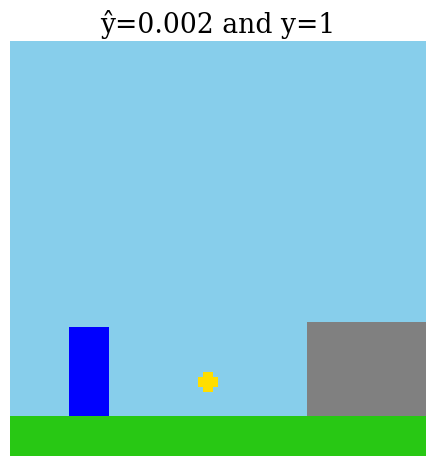

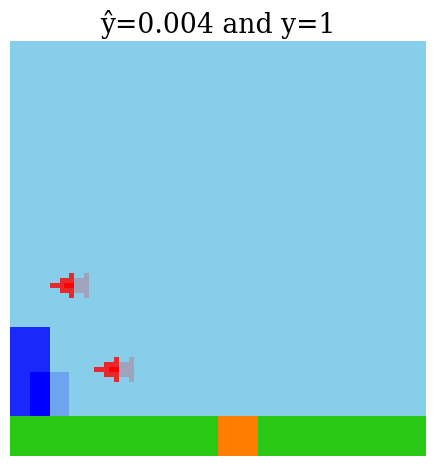

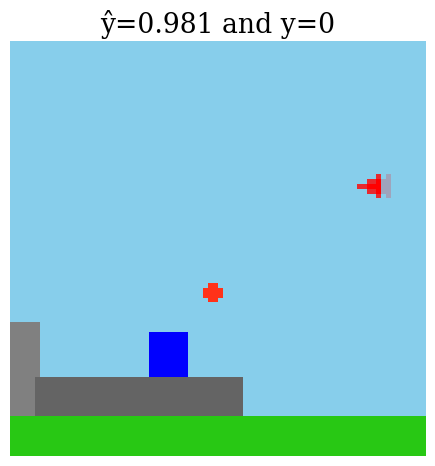

Concept: Player on grass


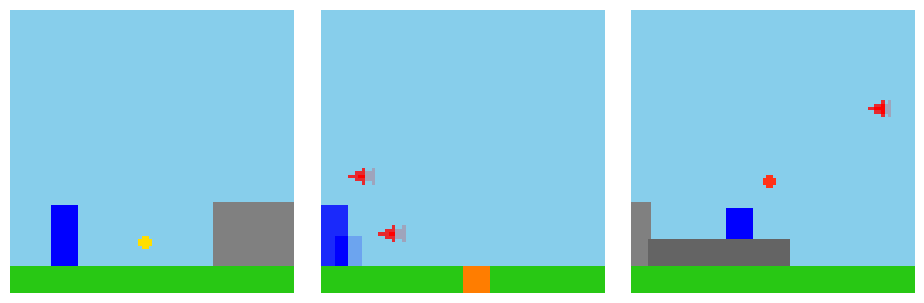

Concept: Player on wall


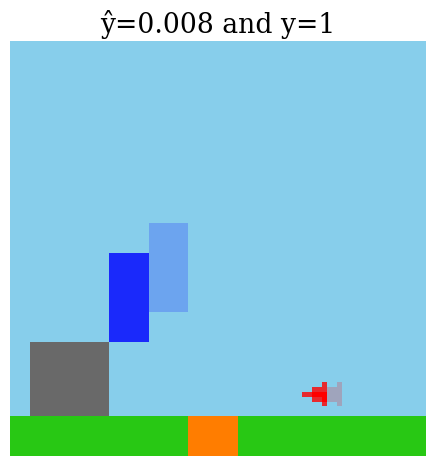

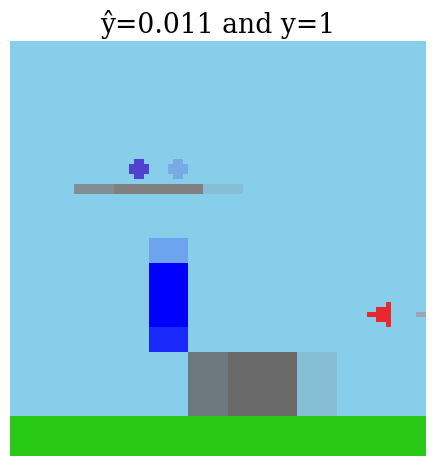

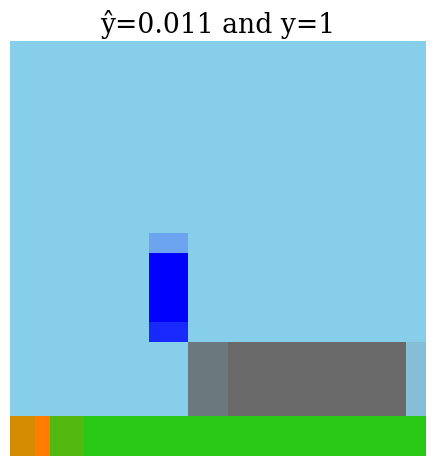

Concept: Player on wall


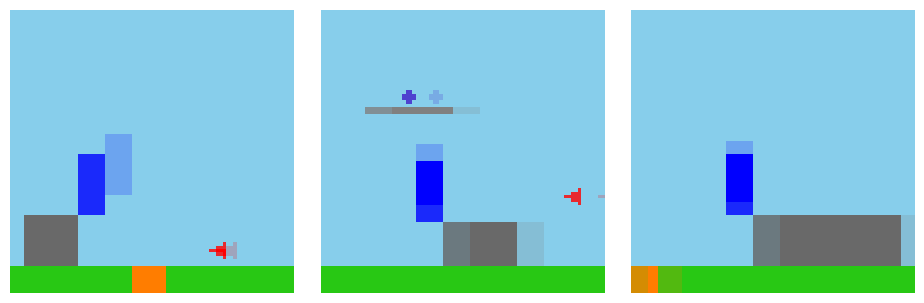

Concept: Player in air


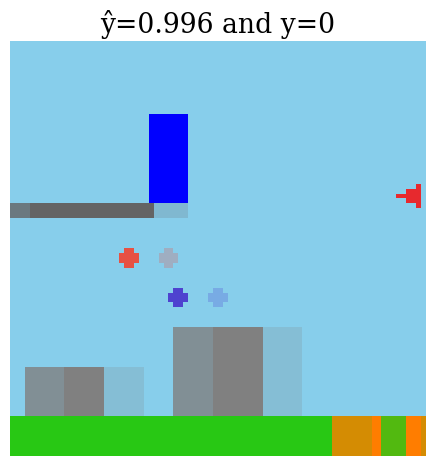

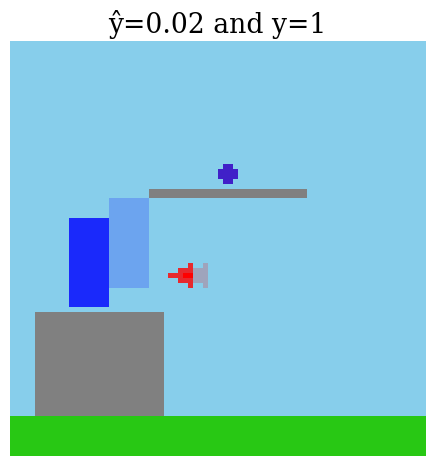

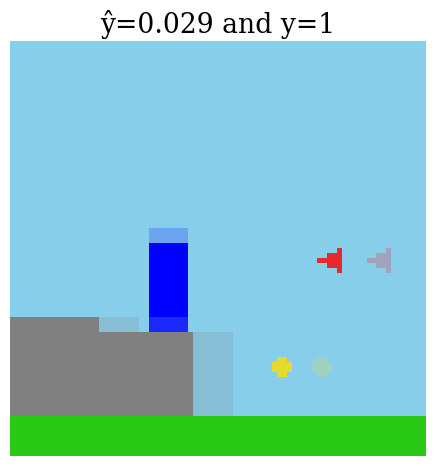

Concept: Player in air


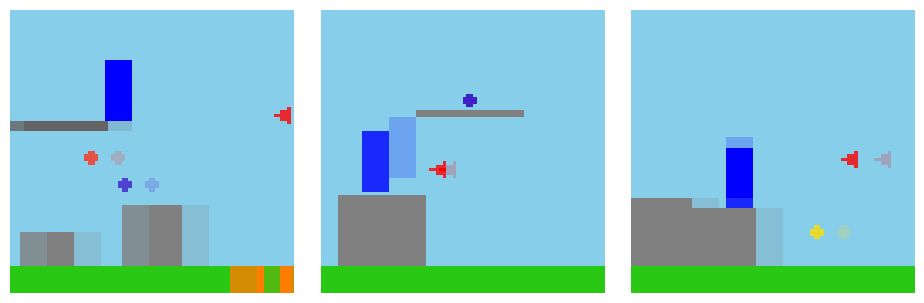

Concept: Player dodging


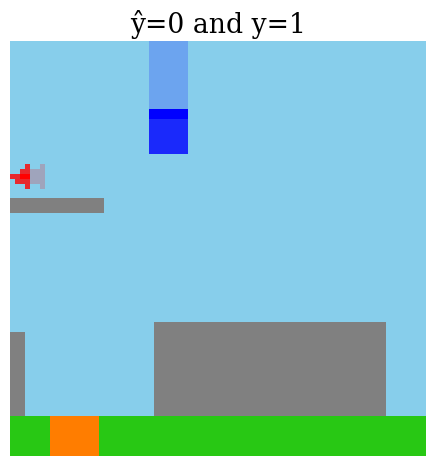

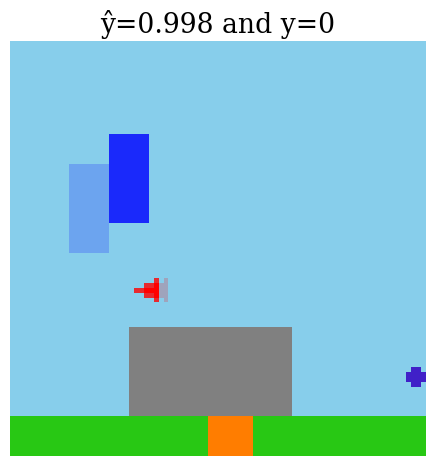

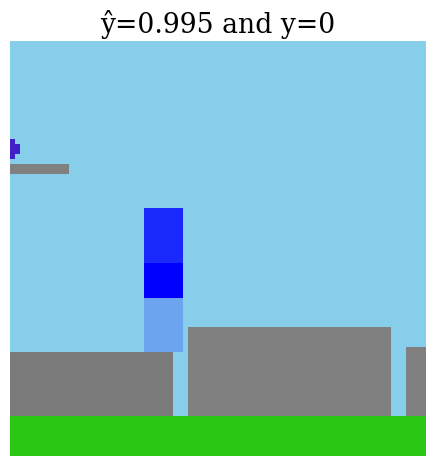

Concept: Player dodging


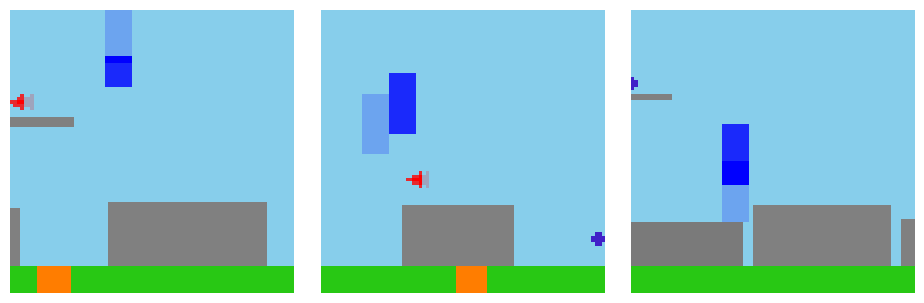

Concept: Player dodging on wall


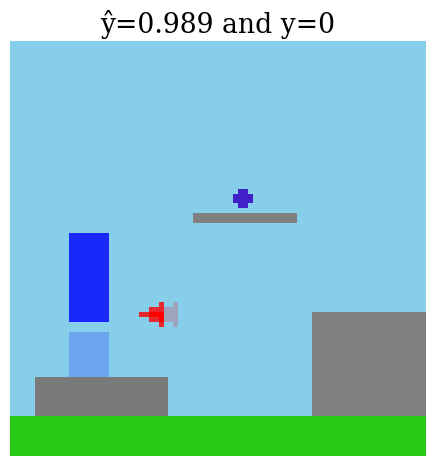

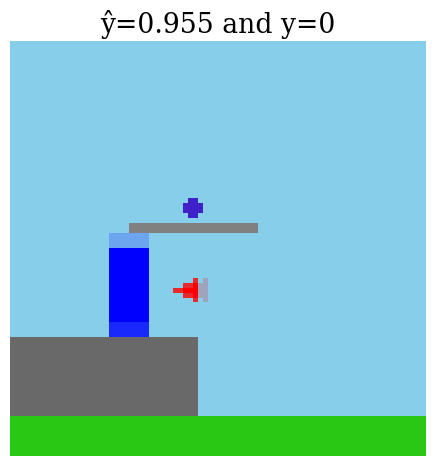

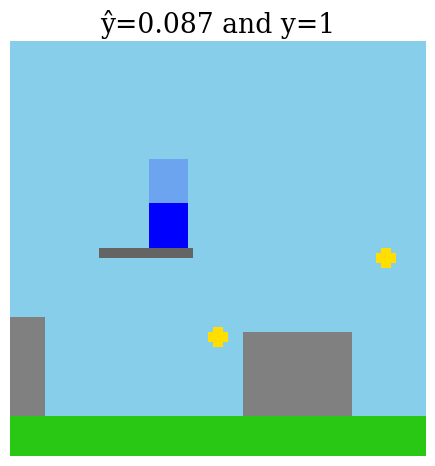

Concept: Player dodging on wall


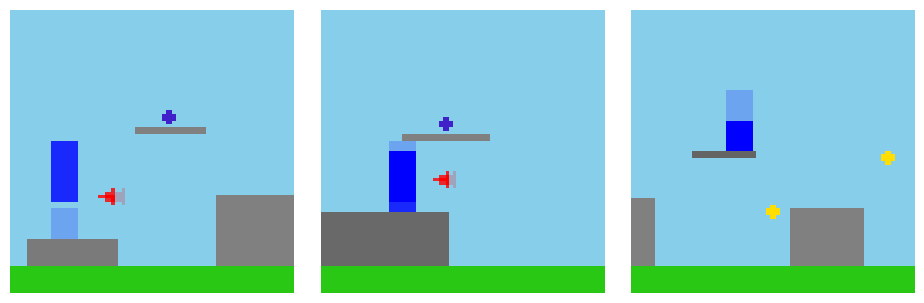

Concept: Player bullet aligned


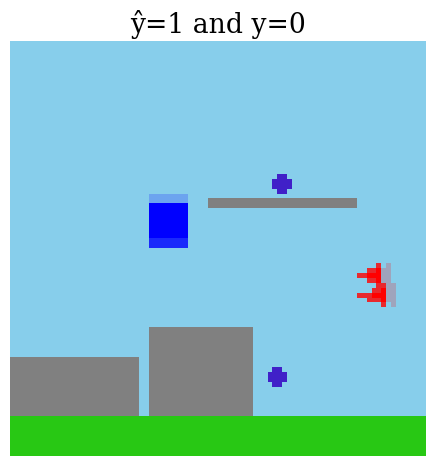

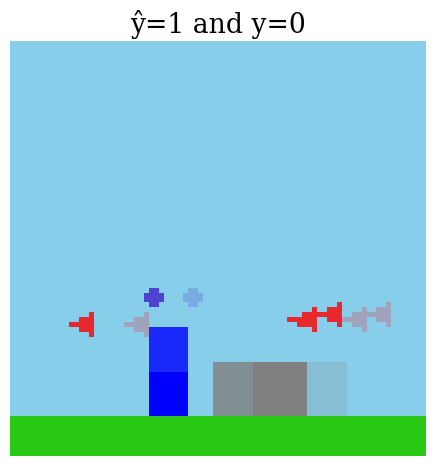

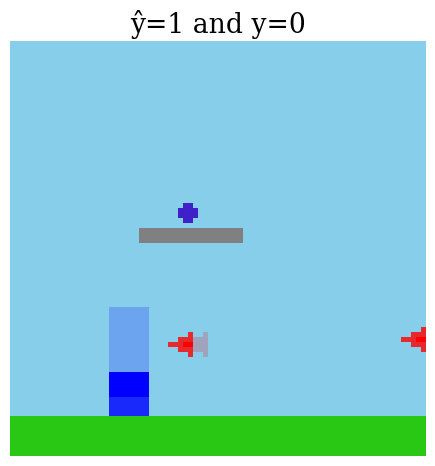

Concept: Player bullet aligned


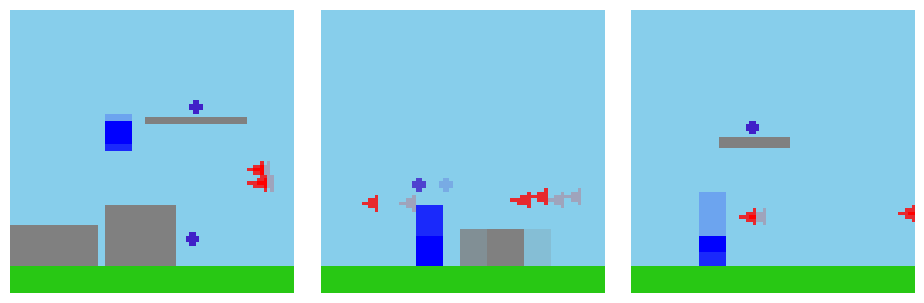

Concept: Player right good coin


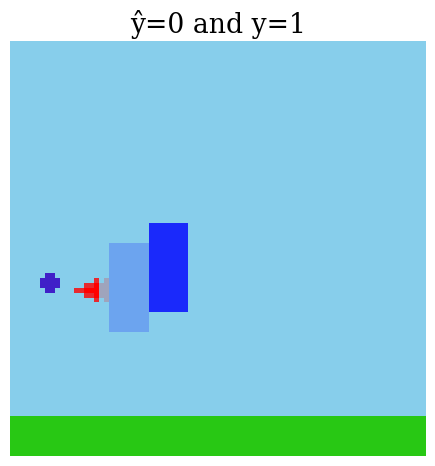

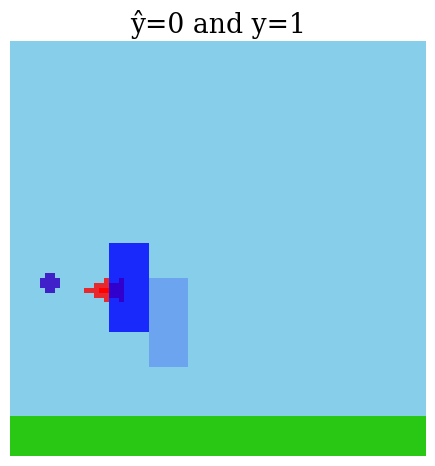

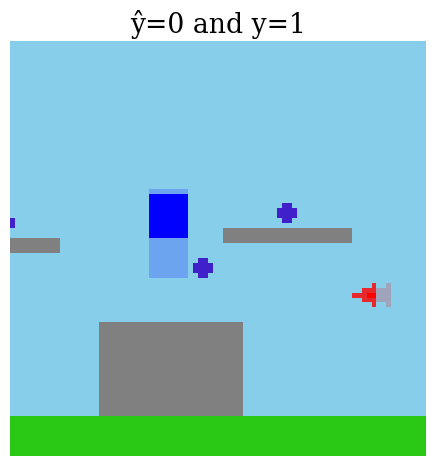

Concept: Player right good coin


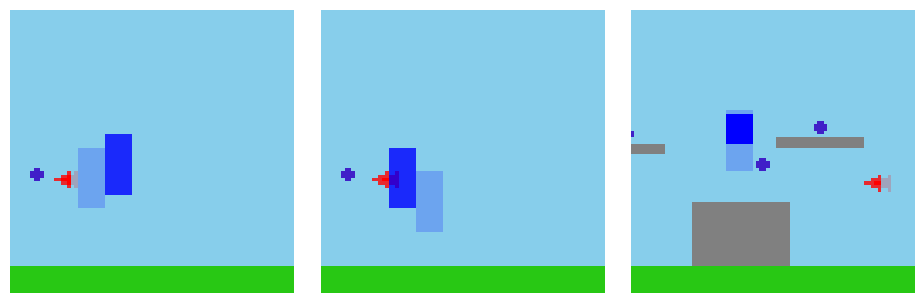

Concept: Total wall area


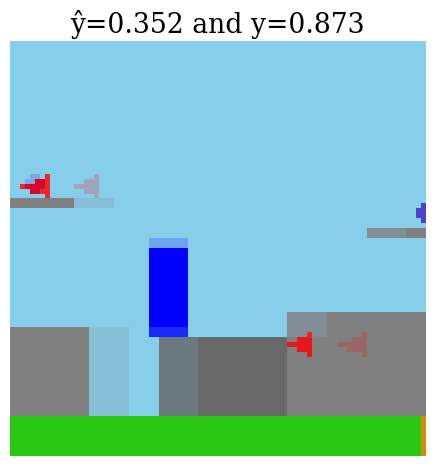

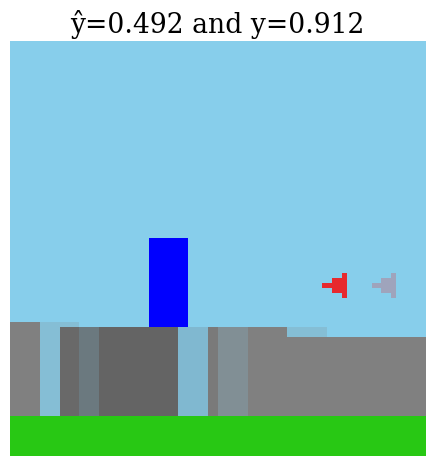

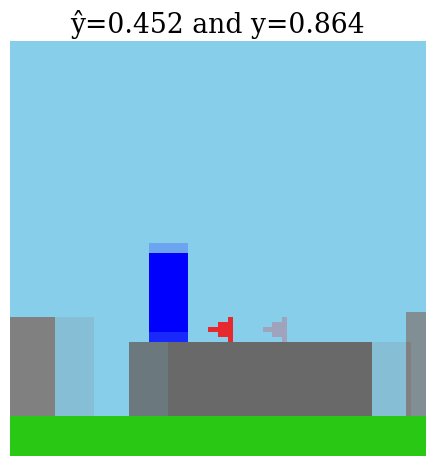

Concept: Total wall area


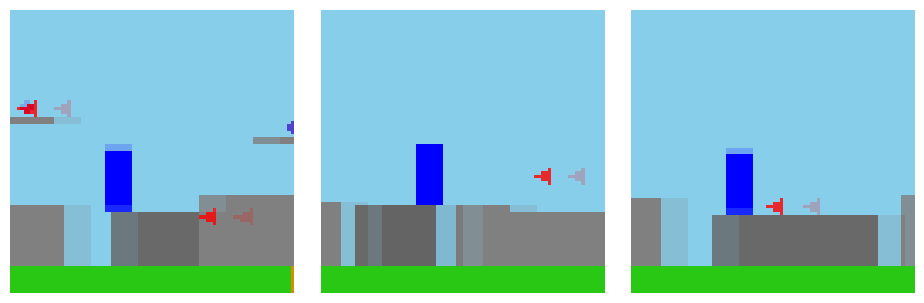

Concept: Visible air wall


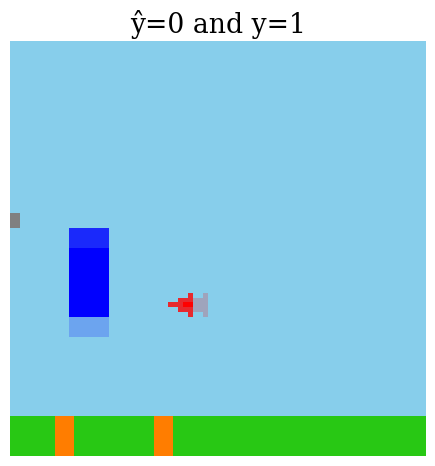

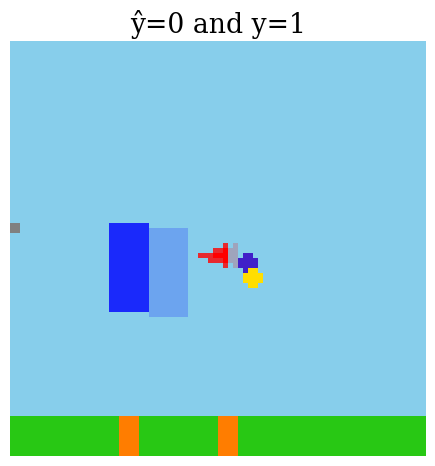

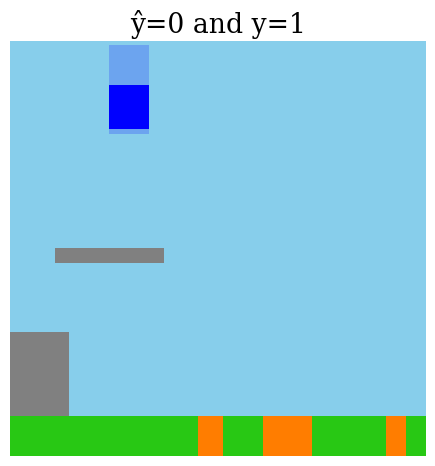

Concept: Visible air wall


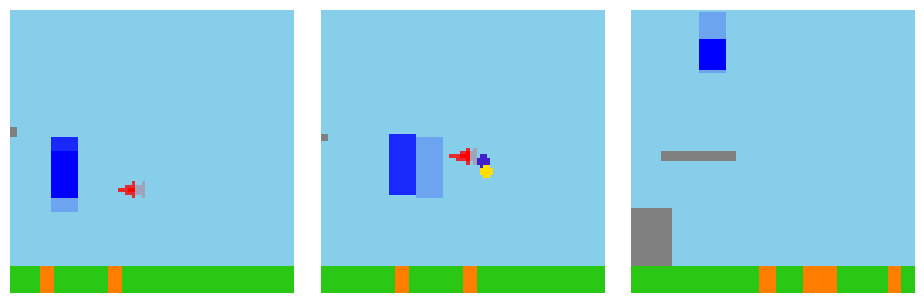

Concept: Visible wall


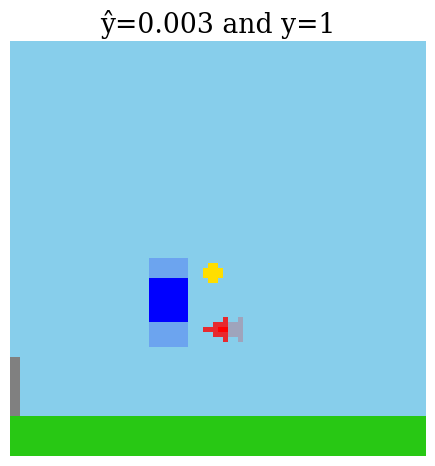

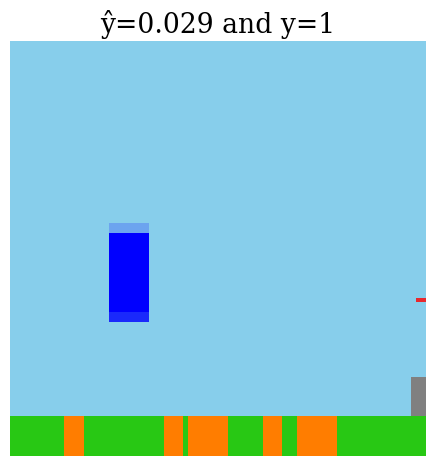

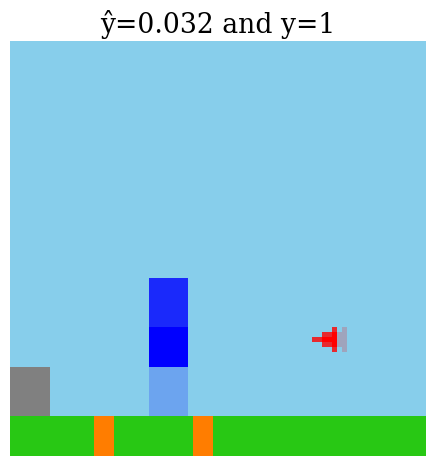

Concept: Visible wall


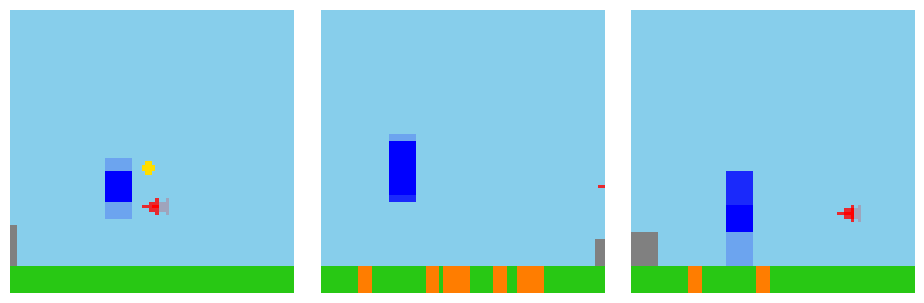

Concept: Visible bullet


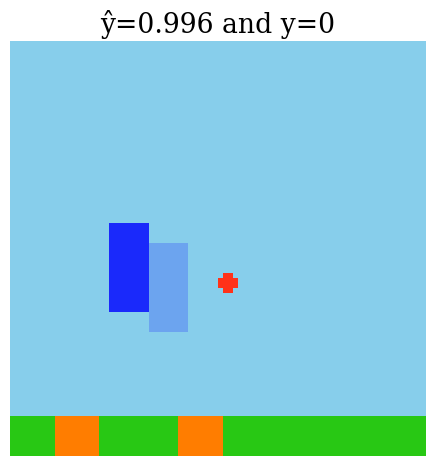

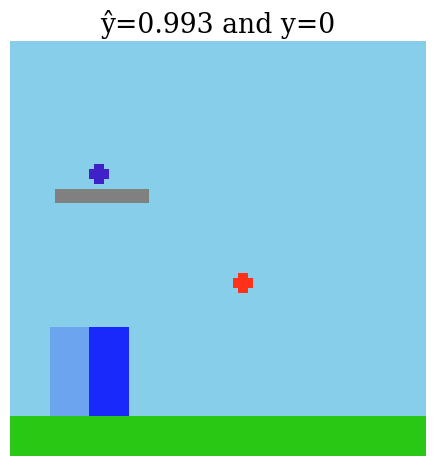

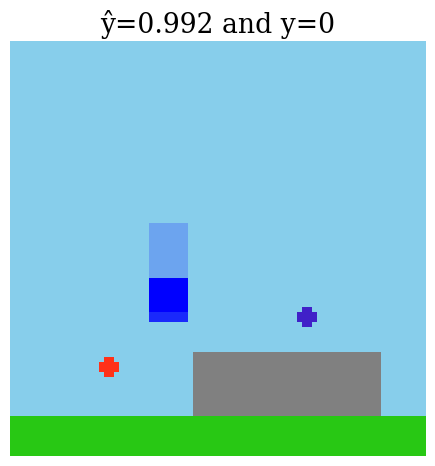

Concept: Visible bullet


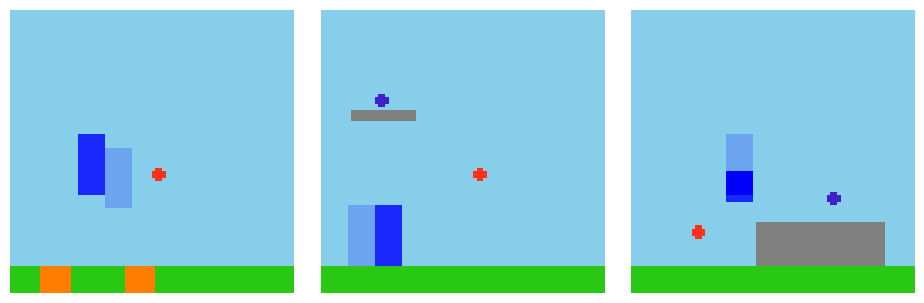

Concept: Visible lava


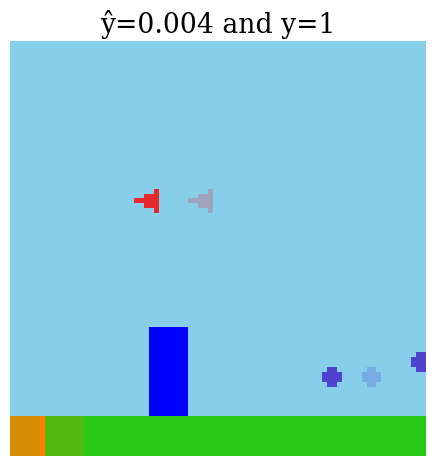

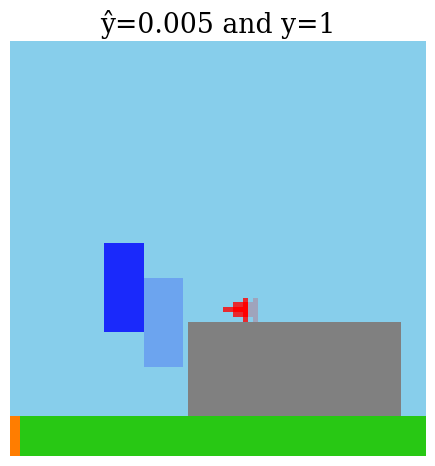

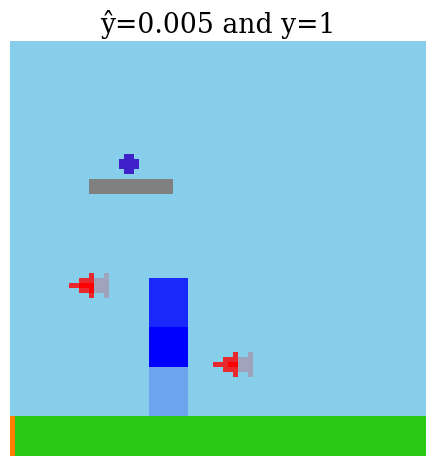

Concept: Visible lava


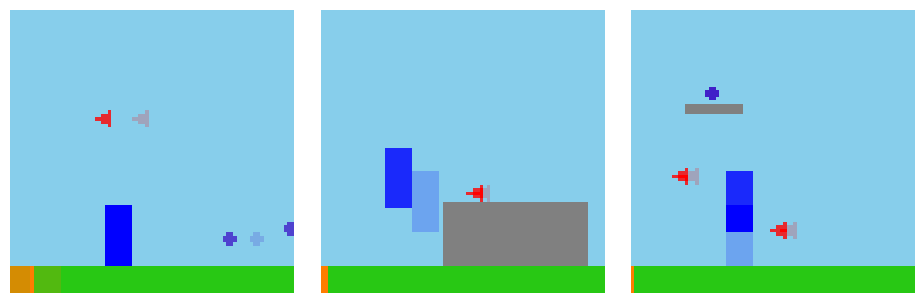

Concept: Visible blue coin


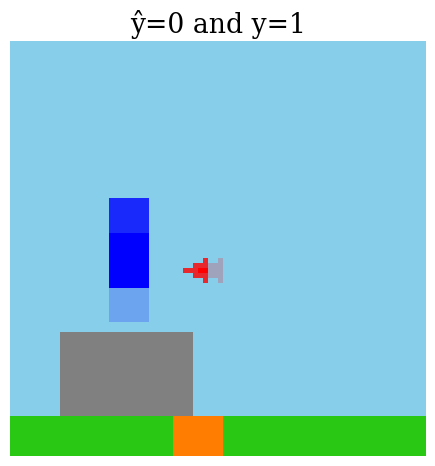

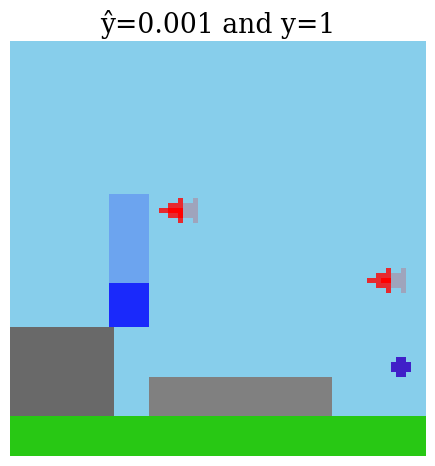

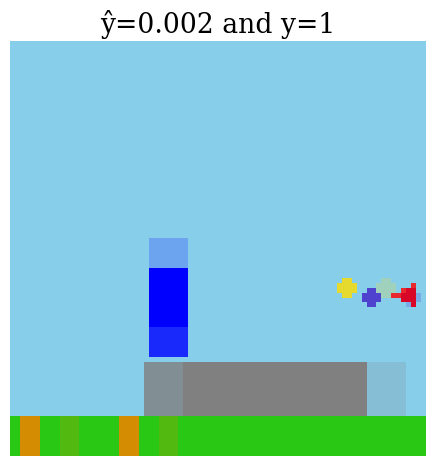

Concept: Visible blue coin


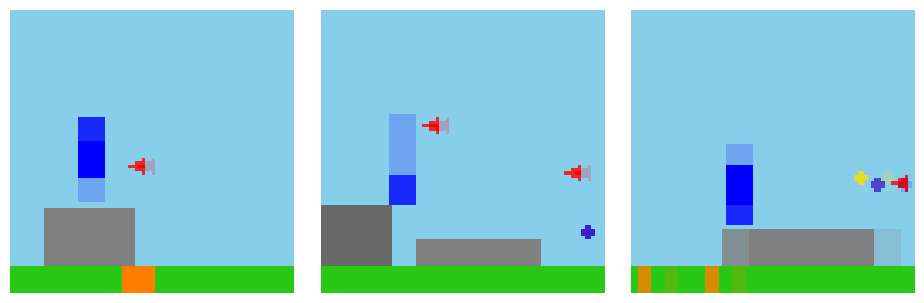

Concept: Visible gold coin


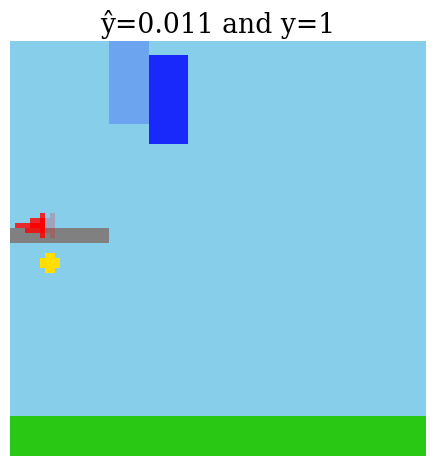

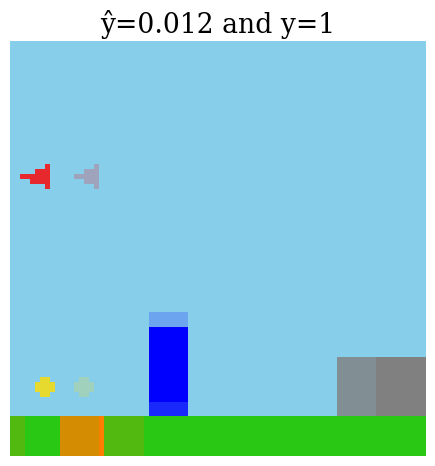

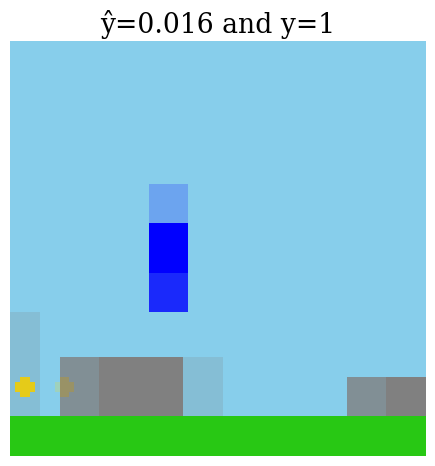

Concept: Visible gold coin


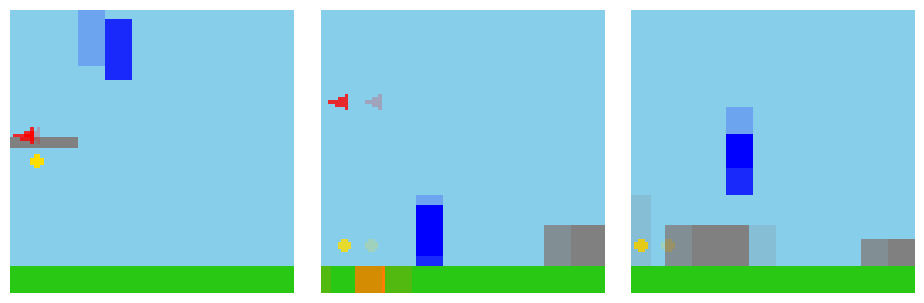

Concept: Visible red coin


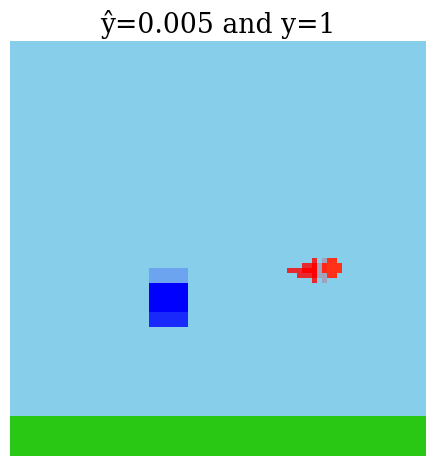

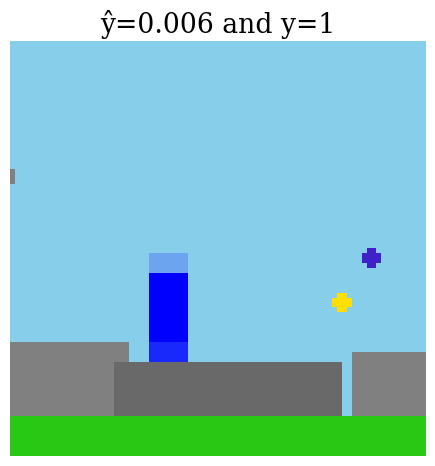

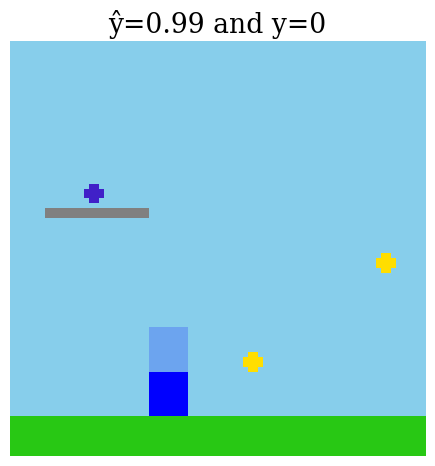

Concept: Visible red coin


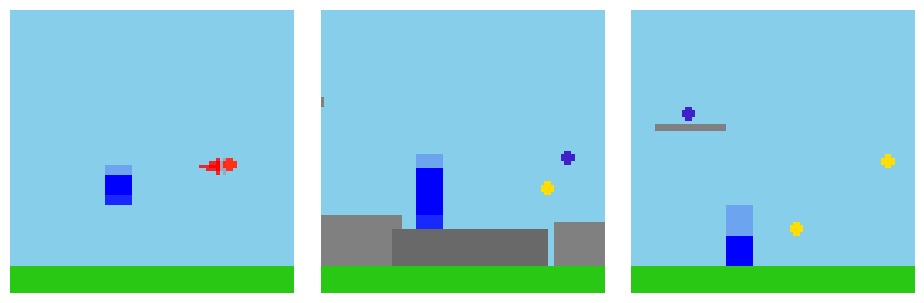

Concept: Visible high coin


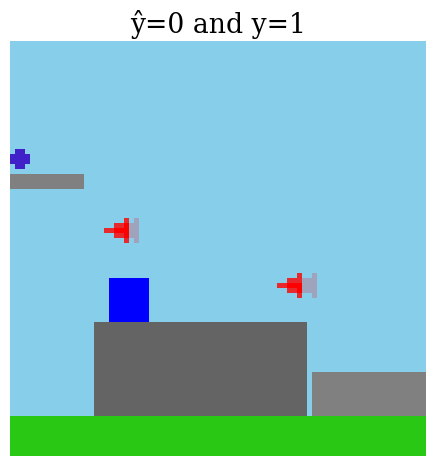

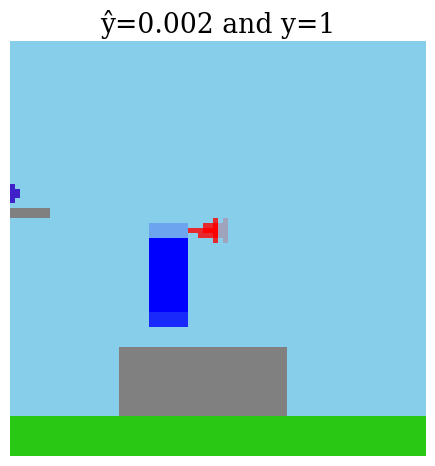

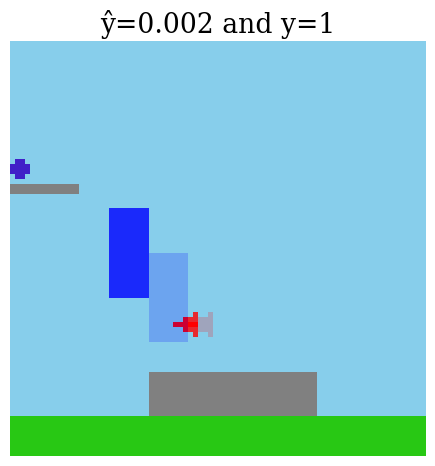

Concept: Visible high coin


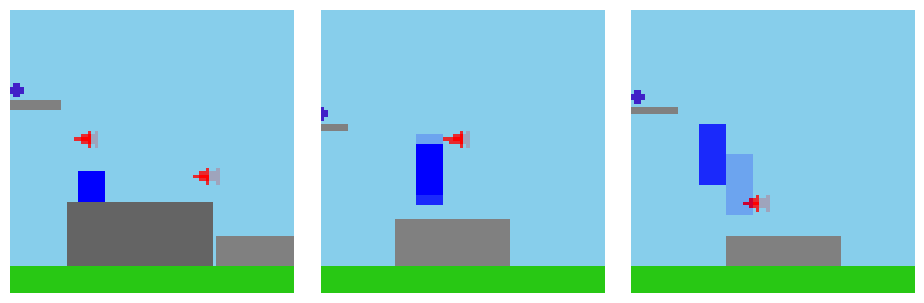

Concept: Visible good low coin


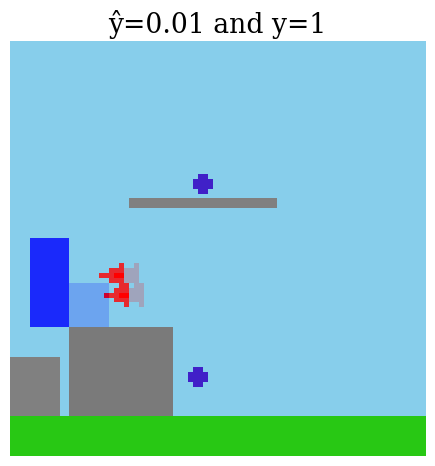

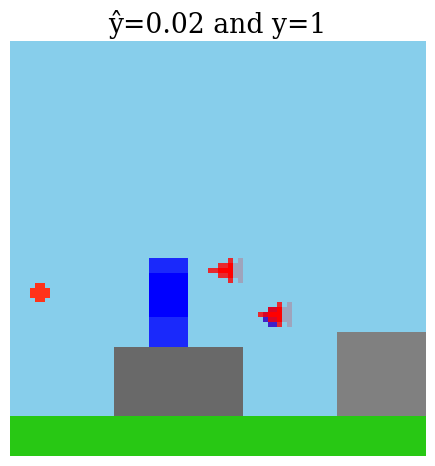

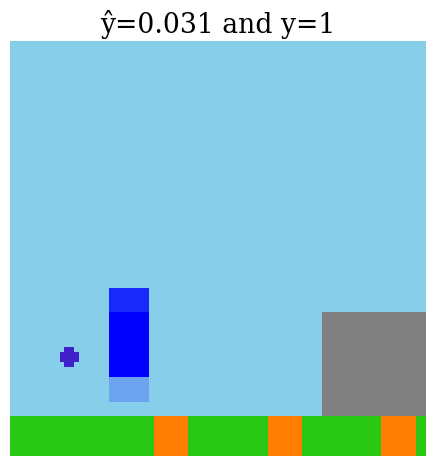

Concept: Visible good low coin


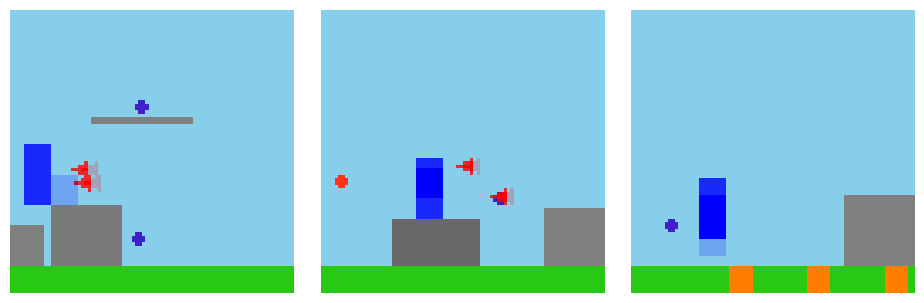

Concept: Event quantity


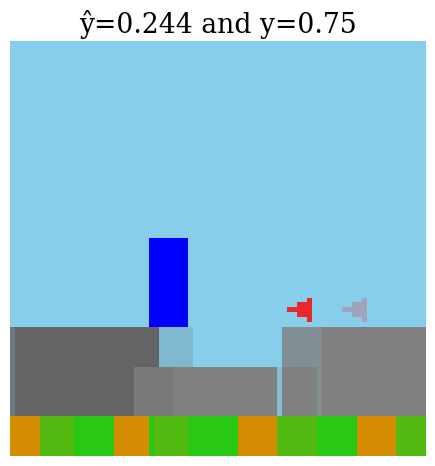

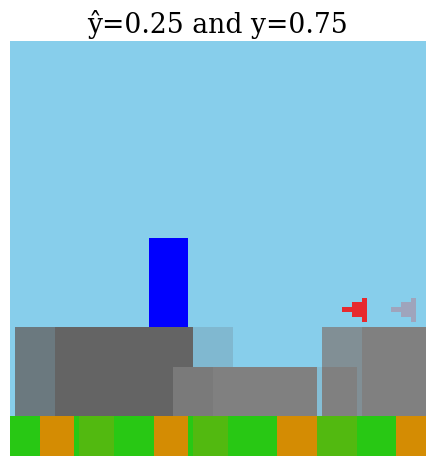

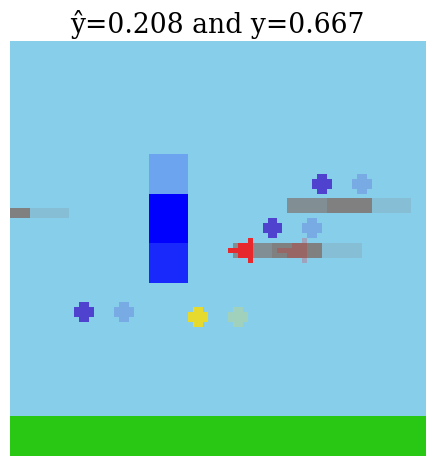

Concept: Event quantity


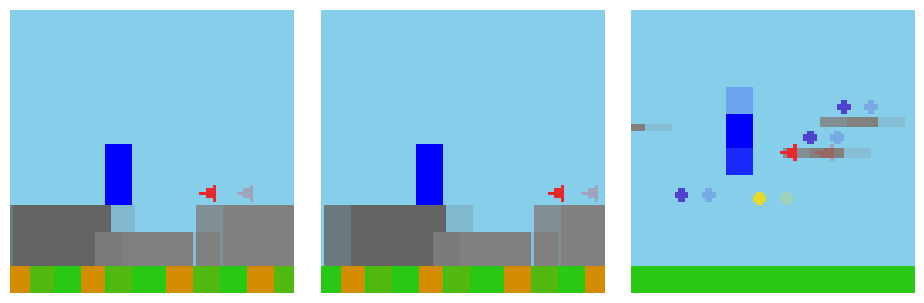

Concept: Good event quantity


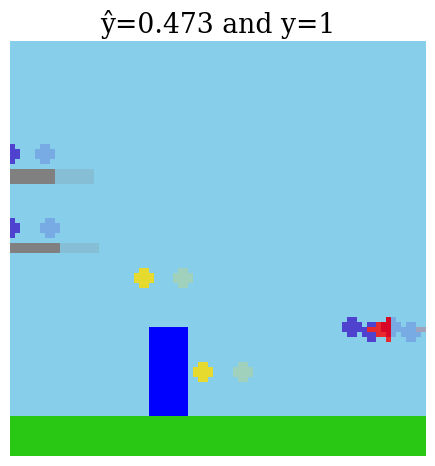

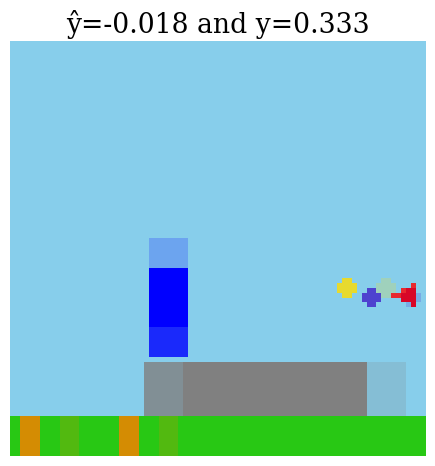

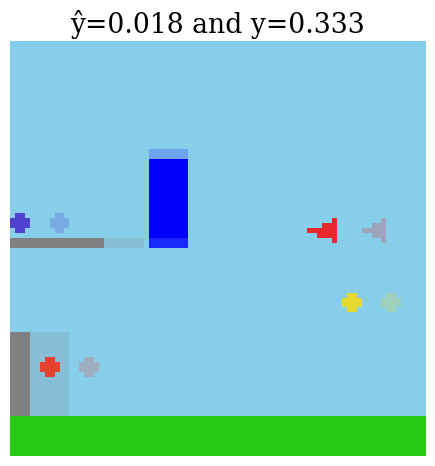

Concept: Good event quantity


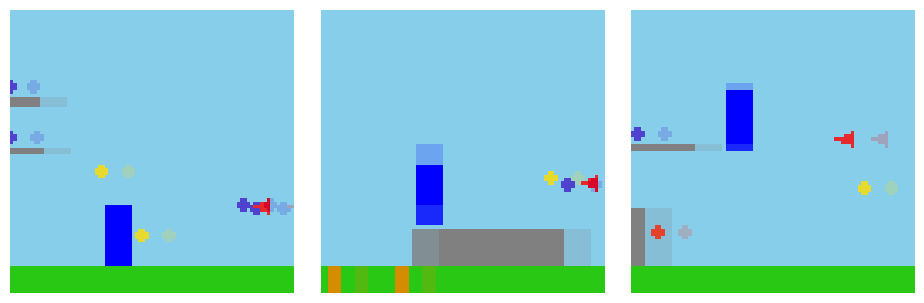

Concept: Bad event quantity


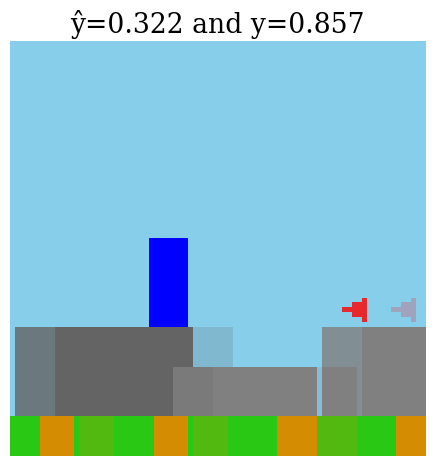

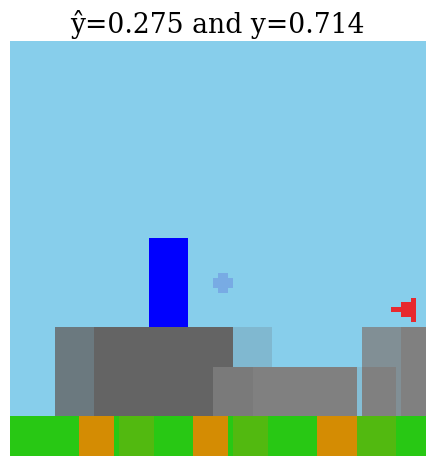

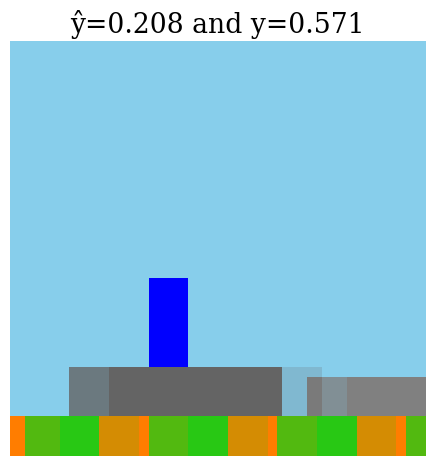

Concept: Bad event quantity


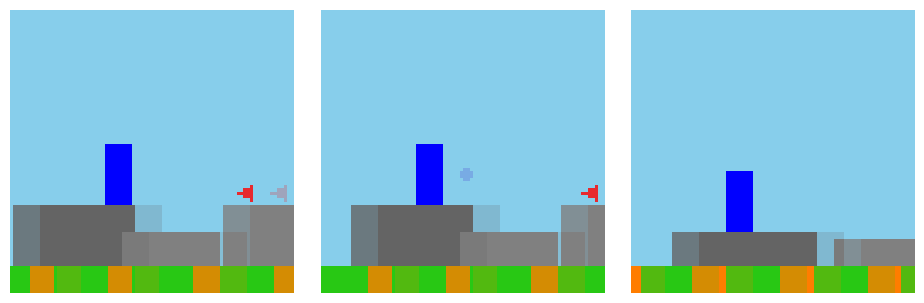

In [5]:
num_images = 3
for concept in concept_instances.values():
    if 'random' in concept.name:
        continue
    print(f"Concept: {concept.plot_name}")
    concept.prepare_data(env_steps, max_size=10000)
    test_obs = concept.test_obs
    test_values = concept.test_values
    _, test_acts_dict = model(torch.Tensor(test_obs), return_acts=True)
    test_acts = test_acts_dict[layer].detach()
    probe, score = concept.load_torch_probe()
    
    # Calculate residuals and sort them to find the worst predictions
    pred = probe(test_acts).detach().squeeze().numpy()
    residuals = np.abs(pred - test_values)
    worst = residuals.argsort()[-num_images:][::-1]  # Get the top x worst residuals
    
    # Save all n images individually
    for num, idx in enumerate(worst):
        res = f"ŷ={pred[idx]:.3f}".rstrip('0').rstrip('.') + f" and y={test_values[idx]:.3f}".rstrip('0').rstrip('.')
        plt.figure(figsize=set_size_and_get_figsize(1))
        plt.title(res)
        plt.axis('off')
        plt.imshow(concept.test_obs[idx])
        plt.savefig(f'figures/residuals/{concept.plot_name}_{num}.png', bbox_inches='tight')
        plt.show()
        
    fig, axes = plt.subplots(1, num_images, figsize=set_size_and_get_figsize(1.3))
    for idx, ax in zip(worst, axes):
        ax.imshow(concept.test_obs[idx])
        res = f"ŷ={pred[idx]:.3f}".rstrip('0').rstrip('.') + f" and y={test_values[idx]:.3f}".rstrip('0').rstrip('.')
        # ax.set_title(res)
        ax.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'figures/residuals/{concept.plot_name}.png', bbox_inches='tight')
    print(f"Concept: {concept.plot_name}")
    plt.show()